# Learning representations of network activity evolution under the classification loss

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns

import numpy as np
import pandas as pd

import torch
import wandb

import sys
sys.path.append('../src')

In [2]:
from data.image_data import fetch_dataset_from_hf, balanced_train_subsets
from data.activity_data import ActivityGradientDataDict, classification_output

from models.TTA_model import ClassifierWithTTA

W1010 13:16:35.008000 19730 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


import error: No module named 'triton'


## Ground truth gradient steps

In [3]:
# Unweildy since this loads everything before sampling
train, _ = balanced_train_subsets(total_size=400, train_fraction=0.5)


In [5]:
classifier_model = ClassifierWithTTA.load_from_file('../base_models_for_TTA/vit2_full_sync')
classifier_model = classifier_model.to('mps')

activity_ds = ActivityGradientDataDict(classifier_model, classifier_model.embedding.vit, 
                                       train,
                                       None,
                                       device='mps',
                                       shuffle=False,
                                       batch_size=len(train)
                                      )

Successfully loaded weights from ../base_models_for_TTA/vit2_full_sync


### First, compare outputs against each other

In [7]:
images, labels = train[:]

activity, gradient = next(iter(activity_ds['train']))
activity1, gradient1 = next(iter(activity_ds['train']))

In [8]:
(activity - activity1).abs().max()

tensor(49.4682, device='mps:0')

In [9]:
classifier_model.embedding.vit.config.mask_ratio

0.0

Note that activity is not the same between individual runs.

The masking ratio is zero, so the masking is not the cause of the randomization. Doing a deep dive into the huggingface code, I found that this is a result of the way masking is performed: the patch embeddings are randomly shuffled during the process of masking. So, it is randomization of token ordering that causes these changes. Notably, the activity vectors are not simply shuffled versions of one another, I think this is because token position embeddings are performed at the level of token position.

In [10]:
from data.activity_data import classification_output

base_outputs = classifier_model(images.to('mps')).logits.cpu()

intercepted_outputs = classification_output(classifier_model, activity).cpu()
intercepted_outputs1 = classification_output(classifier_model, activity1).cpu()

In [11]:
print(f'Accuracy: {(base_outputs.argmax(1) == labels).to(float).mean()}')

Accuracy: 0.825


In [12]:
print(f'Agreement with intercepts: {(base_outputs.argmax(1) == intercepted_outputs.argmax(1)).to(float).mean()}')

Agreement with intercepts: 1.0


In [13]:
print(f'Agreement with intercepts (rep): {(base_outputs.argmax(1) == intercepted_outputs1.argmax(1)).to(float).mean()}')

Agreement with intercepts (rep): 1.0


Despite differences, the base outputs and intercepted outputs agree with one another.

### Gradient steps: do ground truth steps improve classification?

In [14]:
def classifier_results(activity, labels):
    outputs = classification_output(classifier_model, activity).cpu()
    output_probs = torch.nn.functional.softmax(outputs, dim=1)

    probability_of_label = output_probs[range(len(labels)), labels]
    decoding = outputs.argmax(1)
    return probability_of_label, decoding

def plot_comparisons(accumulator):
    accumulator['diff'] = accumulator['perturbed_probs'] - accumulator['base_probs']
    plt.subplots(2,2)
    ax=plt.subplot(2,2,1)
    accumulator.plot.scatter(x='base_probs', y='perturbed_probs', ax=ax)
    ax.plot(np.linspace(0,1), np.linspace(0,1), color='C1')
    ax=plt.subplot(2,2,2)
    accumulator.plot.scatter(x='base_probs', y='diff', ax=ax)
    ax.plot(np.linspace(0,1), np.zeros(50), color='C1')

    ax=plt.subplot(2,2,3)
    ax.bar(['increased prob', 'decreased prob'],
           [sum(accumulator['diff'] >0) / len(accumulator), sum(accumulator['diff'] <0) / len(accumulator)])

    ax=plt.subplot(2,2,4)
    ax.bar(['became correct', 'became incorrect'],
           [len( accumulator[(accumulator.base_class != accumulator.gt_labels) &
               (accumulator.perturbed_class == accumulator.gt_labels)] ),
            len( accumulator[(accumulator.base_class == accumulator.gt_labels) &
               (accumulator.perturbed_class != accumulator.gt_labels)] )
           ])

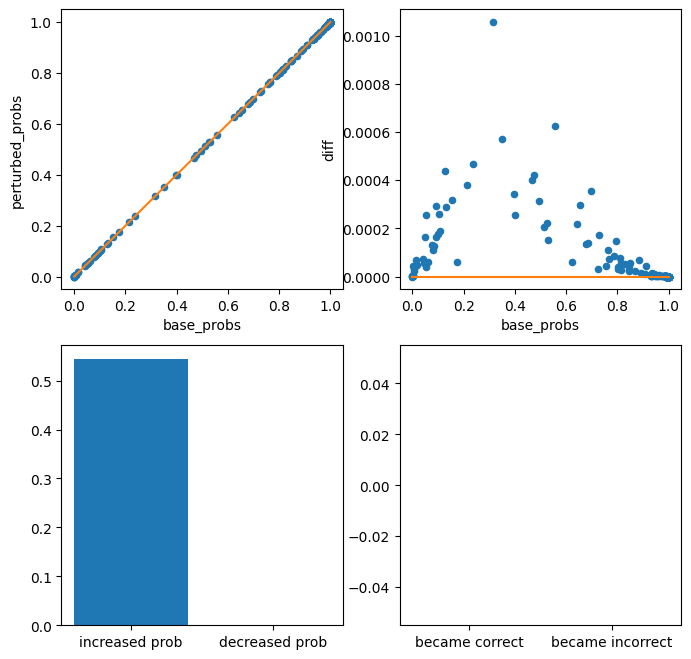

In [15]:
figsize(8,8)
step =1E-1
base_probs, base_decoding = classifier_results(activity, labels)
perturbed_probs, perturbed_decoding = classifier_results(activity - step*gradient, labels)

accumulator = pd.DataFrame({'base_probs': base_probs.tolist(),
                            'perturbed_probs': perturbed_probs.tolist(),
                            'gt_labels': labels.tolist(),
                            'base_class': base_decoding.tolist(),
                            'perturbed_class':perturbed_decoding.tolist()
                           })

plot_comparisons(accumulator)

Note that the differences are extremely small, but they are all increasing. However, it is still not enough to flip any classifications to become correct

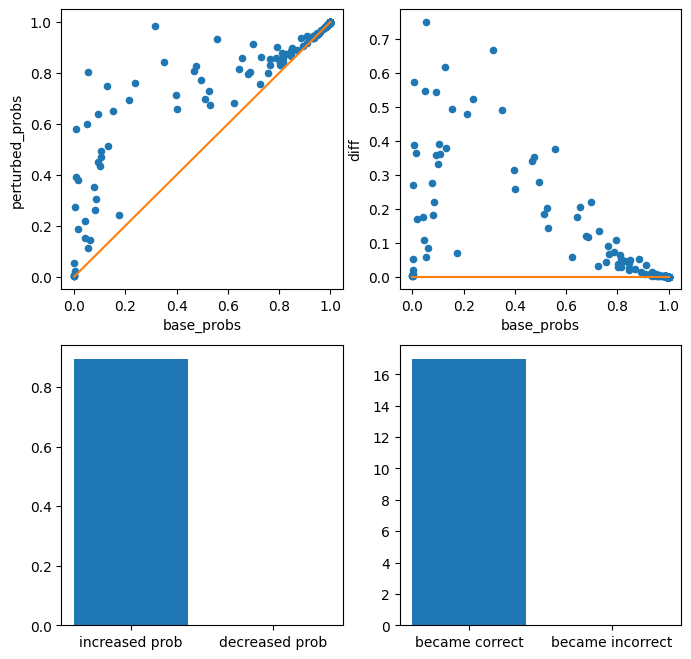

In [21]:
step = 100
base_probs, base_decoding = classifier_results(activity, labels)
perturbed_probs, perturbed_decoding = classifier_results(activity - step*gradient, labels)

accumulator = pd.DataFrame({'base_probs': base_probs.tolist(),
                            'perturbed_probs': perturbed_probs.tolist(),
                            'gt_labels': labels.tolist(),
                            'base_class': base_decoding.tolist(),
                            'perturbed_class':perturbed_decoding.tolist()
                           })

plot_comparisons(accumulator)

In [17]:
(base_outputs.argmax(1) != labels).sum()

tensor(35)

By cranking up the gradient steps, we can cause all of the miss-classified points to become correctly classified:
- Step size 500 is sufficient for full correct outputs.
- We do see some diminishing returns, but only at very large step sizes ~5000, and even then, it is rare.
- Step size 100 seems reasonable for a strong signal to learn on.

At first blush this looks very surprising (especially compered to the step sizes that are used in neural network training). However, I think that the key difference is the fact that this is an activity perturbation, rather than a weight perturbation, and so seems to be better behaved under large step sizes.

I a way, I think that this is a strong positive signal for our overall objective: it indicates that the loss surface does not have many peaks.

## Learned gradients


In [3]:
from omegaconf import OmegaConf
from hydra import compose, initialize_config_dir
from pathlib import Path

from models.TTA_model import ClassifierWithTTA
from models.loss_models import EmbeddingToGradient, EmbeddingPropagation

from data.image_data import fetch_dataset_from_hf
from data.activity_data import ActivityGradientDataDict

from training.loss_training import make_trainer


def reload_hydra_config(run_dir):
    hydra_dir = Path(run_dir) / ".hydra"
    with initialize_config_dir(str(hydra_dir), job_name="replay"):
        cfg = compose(config_name="config")
    return cfg

base_dir = '/Users/luke/Documents/activeProjects/TTA_working/'
gradient_overfit_dir = 'experiments_loss/2025-10-09(21:55:06)-gradient_overfit/'
propagation_overfit_dir = 'experiments_loss/2025-10-09(22:31:32)-propagation_overfit/'
propagation_full_dir = 'experiments_loss/2025-10-10(00:32:47)-propagation_large_data/'

### Learning on the gradients

This appears to produce little improvement even on a small subset, when training on gradients multiplied by a large step size.

#### Direct gradient learning - overfitting

Observations from the learning curves: the model seems to learn something about the gradients, but not much:
- the loss becomes small
- the probability improvements remain close to 50%, and no points see improved classification

Not a very promising approach overall.

In [15]:
working_dir = base_dir+gradient_overfit_dir
cfg = reload_hydra_config(working_dir)

images_train, images_val = balanced_train_subsets(**cfg.image_data)
classifier_model = ClassifierWithTTA.load_from_file('../' + cfg.base_model.ckpt)

# Initialize loss model and activity dataset
loss_model = EmbeddingToGradient.load_from_checkpoint(working_dir+'/checkpoints/best.ckpt',
                                                   classifier_model=classifier_model,
                                                   **cfg.loss_model.params)
activity_ds = ActivityGradientDataDict(classifier_model,
                                       classifier_model.embedding.vit,
                                       images_train, images_train,
                                       **cfg.activity_data
                                       )

/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_19404/873921310.py:16: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize_config_dir(str(hydra_dir), job_name="replay"):


Successfully loaded weights from ../base_models_for_TTA/vit2_full_sync


In [42]:
all_batches = list(iter(activity_ds['val']))
all_data = list(zip(*all_batches))
activity, gradient, labels = [torch.concat(tensors) for tensors in all_data]

In [44]:
predictions = loss_model(activity, gradient)
grad_pred = predictions.predictions

In [45]:
predictions.loss

tensor(0.0052, device='mps:0', grad_fn=<MeanBackward0>)

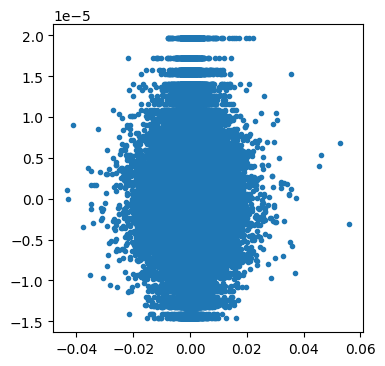

In [47]:
figsize(4,4)
_=plt.scatter(gradient.view(-1).cpu().numpy(), grad_pred.view(-1).detach().cpu().numpy(), marker='.')
#plt.xlim([-0.04, 0.04])
#plt.ylim([-0.04, 0.04])

The gradients mostly seem to have learned to be small, but little else about the structure

In [59]:
acc = (labels == classification_output(classifier_model.to('mps'), activity.to('mps')).cpu().argmax(1)).to(float).mean()
print(f'Baseline accuracy: {acc}')

Baseline accuracy: 0.825


In [61]:
acc = (labels == classification_output(classifier_model.to('mps'), activity.to('mps') - loss_model.step_size * grad_pred.to('mps')
                                      ).cpu().argmax(1)).to(float).mean()
print(f'Perturbed accuracy: {acc}')

Perturbed accuracy: 0.825


#### Propagation learning - overfitting

Produces excellent learning curves:
- 16% accuracy improvement
- 70% showed probability improvements.

In [4]:
working_dir = base_dir+propagation_overfit_dir
cfg = reload_hydra_config(working_dir)

images_train, images_val = balanced_train_subsets(**cfg.image_data)
classifier_model = ClassifierWithTTA.load_from_file('../' + cfg.base_model.ckpt)

# Initialize loss model and activity dataset
loss_model = EmbeddingPropagation.load_from_checkpoint(working_dir+'/checkpoints/best.ckpt',
                                                   classifier_model=classifier_model,
                                                   **cfg.loss_model.params)
activity_ds = ActivityGradientDataDict(classifier_model,
                                       classifier_model.embedding.vit,
                                       images_train, images_train,
                                       **cfg.activity_data
                                       )

/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_19656/873921310.py:16: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize_config_dir(str(hydra_dir), job_name="replay"):


Successfully loaded weights from ../base_models_for_TTA/vit2_full_sync


In [5]:
all_batches = list(iter(activity_ds['val']))
all_data = list(zip(*all_batches))
activity, gradient, labels = [torch.concat(tensors) for tensors in all_data]

propagation_gt = activity - loss_model.step_size * gradient

In [6]:
predictions = loss_model(activity,  propagation_gt)
propagation_pred = predictions.predictions

In [7]:
predictions.loss

tensor(0.0008, device='mps:0', grad_fn=<MseLossBackward0>)

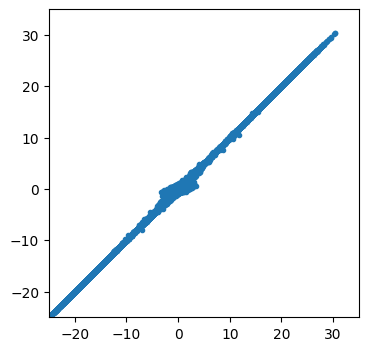

In [8]:
figsize(4,4)
_=plt.scatter(propagation_gt.view(-1).cpu().numpy(),
              propagation_pred.view(-1).detach().cpu().numpy(), marker='.')
plt.xlim([-25, 35])
_=plt.ylim([-25, 35])

Nice correlation, albeit with some inaccuracies near zero. Clearly the target values are generally much larger than, probably explaining why it is easier to learn.

In [9]:
acc = (labels == classification_output(classifier_model, activity).cpu().argmax(1)).to(float).mean()
print(f'Baseline accuracy: {acc}')

Baseline accuracy: 0.825


In [10]:
acc = (labels == classification_output(classifier_model.to('mps'),
                                       propagation_pred
                                      ).cpu().argmax(1)).to(float).mean()

print(f'Perturbed accuracy: {acc}')

Perturbed accuracy: 0.985


As observed during validation, 16% accuracy improvement. Very promising.

#### Propagation learning - large data

Observations from the loss curves: 

They look ok: 57% probability improvements, 1.5% accuracy improvement. Everything plateaus after about 50 epochs with the training learning curve becoming quite noisy.

In [18]:
working_dir = base_dir+propagation_full_dir
cfg = reload_hydra_config(working_dir)

images_train, images_val = balanced_train_subsets(**cfg.image_data)
classifier_model = ClassifierWithTTA.load_from_file('../' + cfg.base_model.ckpt)

# Initialize loss model and activity dataset
loss_model = EmbeddingPropagation.load_from_checkpoint(working_dir+'/checkpoints/best.ckpt',
                                                   classifier_model=classifier_model,
                                                   **cfg.loss_model.params)
activity_ds = ActivityGradientDataDict(classifier_model,
                                       classifier_model.embedding.vit,
                                       images_train, images_val,
                                       **cfg.activity_data
                                       )

/var/folders/_j/lst7wc811v14243bptx2xw640000gn/T/ipykernel_19730/873921310.py:16: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize_config_dir(str(hydra_dir), job_name="replay"):


Successfully loaded weights from ../base_models_for_TTA/vit2_full_sync


In [19]:
from itertools import islice

all_batches = list(islice(iter(activity_ds['val']), 25))
all_data = list(zip(*all_batches))
activity, gradient, labels = [torch.concat(tensors) for tensors in all_data]

propagation_gt = activity - loss_model.step_size * gradient

In [20]:
predictions = loss_model(activity,  propagation_gt)
propagation_pred = predictions.predictions

In [21]:
predictions.loss

tensor(0.0013, device='mps:0', grad_fn=<MseLossBackward0>)

Text(0.5, 1.0, 'validation data')

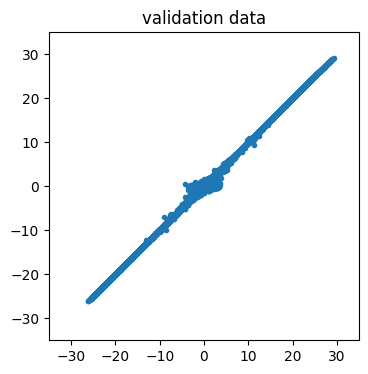

In [22]:
figsize(4,4)
_=plt.scatter(propagation_gt.view(-1).cpu().numpy(),
              propagation_pred.view(-1).detach().cpu().numpy(), marker='.')
plt.xlim([-35, 35])
_=plt.ylim([-35, 35])
plt.title('validation data')

In [23]:
acc = (labels == classification_output(classifier_model, activity).cpu().argmax(1)).to(float).mean()
print(f'Baseline accuracy, val: {acc}')

Baseline accuracy, val: 0.795


In [25]:
acc = (labels == classification_output(classifier_model.to('mps'),
                                       propagation_pred
                                      ).cpu().argmax(1)).to(float).mean()

print(f'Perturbed accuracy, val: {acc}')

Perturbed accuracy, val: 0.82


In [27]:
activity_ds = ActivityGradientDataDict(classifier_model,
                                       classifier_model.embedding.vit,
                                       images_train, images_train,
                                       **cfg.activity_data
                                       )

all_batches = list(islice(iter(activity_ds['val']), 25))
all_data = list(zip(*all_batches))
activity, gradient, labels = [torch.concat(tensors) for tensors in all_data]

propagation_gt = activity - loss_model.step_size * gradient

predictions = loss_model(activity,  propagation_gt)
propagation_pred = predictions.predictions

Text(0.5, 1.0, 'train data')

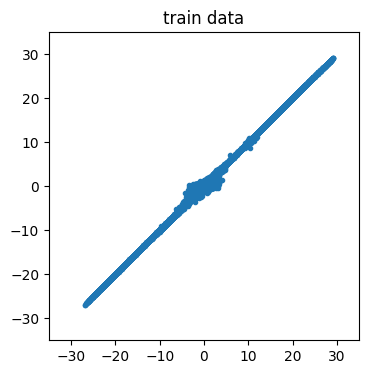

In [28]:
figsize(4,4)
_=plt.scatter(propagation_gt.view(-1).cpu().numpy(),
              propagation_pred.view(-1).detach().cpu().numpy(), marker='.')
plt.xlim([-35, 35])
_=plt.ylim([-35, 35])
plt.title('train data')

In [32]:
acc = (labels == classification_output(classifier_model, activity).cpu().argmax(1)).to(float).mean()
print(f'Baseline accuracy, train: {acc}')

Baseline accuracy, train: 0.8


In [31]:
acc = (labels == classification_output(classifier_model.to('mps'),
                                       propagation_pred
                                      ).cpu().argmax(1)).to(float).mean()

print(f'Perturbed accuracy, train: {acc}')

Perturbed accuracy, train: 0.85


We see 5% accuracy improvement on the training set and ~1.5% improvement on the validaton set.

#### large data propagation, with different hyperparameters

1. increased batch size to 32
   - much smoother train/loss curves
   - faster learning in eval/loss (achieves the best yet seen)
   - seemingly slower improvements in the other validation metrics: struggles to achieve >50% probability improvements on the validation set (i.e. there are more decreases than increases)
   - One important possibility to keep in mind is that there is simply not enough training data (we are using 1/10th of the available data, and that this hampers successful generalization)

